# **Tarea: Identificación de Modelos**

## Alumno: José de Jesús Hernández Higuera

### Matrícula: 224470489

## **1. Transformada de Fourier**

1. Cargue la imagen dog.jpg y conviértala a escala de grises. Use el FFT para comprimir la imagen a diferentes relaciones  de compresión. Grafique el error entre la imagen comprimida y la real en función de la relación de compresión.

*Vamos a dividir esta actividad en dos partes. En la primera, haremos la compresión de la imagen a diferentes relaciones de compresión (es decir, la cantidad de coeficientes conservados). Luego, mostraremos las imagenes para compararlas visualmente (como en el ejemplo visto en clase).*

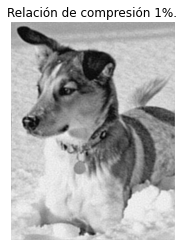

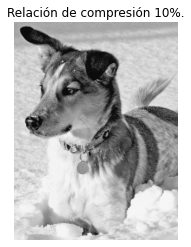

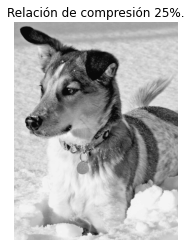

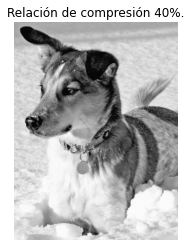

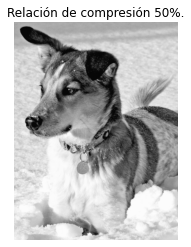

In [1]:
import numpy as np
from matplotlib.image import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

# Loading the image
A = imread('dog.jpeg')
B = rgb2gray(A)

Bt = np.fft.fft2(B)
Btsort = np.sort(np.abs(Bt.reshape(-1))) # Ordenamos de acuerdo a la magnitud

rel_comp = []   # Lista para guardar las relacione de compresión
errores = []    # Lista para almacenar los errores

# Probemos con diferentes relaciones de compresión
for keep in np.linspace(0.01, 0.5, 50):     # relaciones desde el 1 al 50%
    thresh = Btsort[int(np.floor((1 - keep) * len(Btsort)))]    # Umbral
    ind = np.abs(Bt) > thresh   # Encuentra los índices pequeños
    Atlow = Bt * ind        # Umbral para los pequeños índices
    Alow = np.fft.ifft2(Atlow).real # Imagen comprimida

    # Calculemos el error (RMSE) entre la imagen comprimida y la original
    error = np.sqrt(np.mean((B - Alow)**2)) / np.max(B)

    # Guardemos el elemento correspondiente al error y a la relación de compresión
    errores.append(error)
    rel_comp.append(keep)
    #print(keep)

    # Mostremos las imagenes
    if int(keep*100) in [1, 10, 25, 40, 50]:
        plt.figure()
        plt.imshow(Alow, cmap='gray')
        plt.title(f'Relación de compresión {keep*100:.0f}%.')
        plt.axis('off')



*Ahora, grafiquemos el error entre la imagen obtenida y la original.*

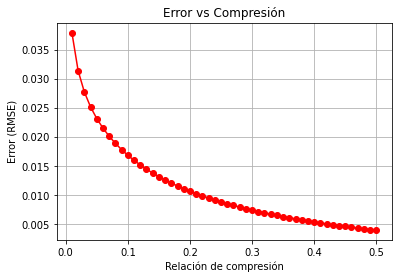

In [2]:
plt.figure()
plt.plot(rel_comp, errores, 'ro-')
plt.xlabel('Relación de compresión')
plt.ylabel('Error (RMSE)')
plt.title('Error vs Compresión')
plt.grid(True)
plt.show()

2. Usa la FFT para resolver la ecuación de Korteweg-de Vries (KdV),

\begin{equation*}
    u_t + u_{xxx} - u u_x = 0
\end{equation*}

en un dominio grande con una condición inicial $u(x;0) = sech(x)$. Grafique la evolución.

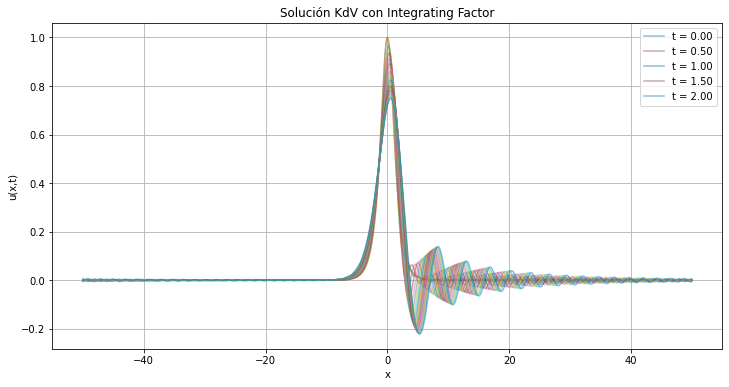

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq

## Definamos los parámetros
# Parámetros del dominio
L = 50.0
N = 2048
dx = 2 * L / N
x = np.linspace(-L, L, N, endpoint=False)

# Parámetros temporales
dt = 0.001      # Tamaño de paso
T = 2.0     # Tiempo final
Nt = int(T / dt)        # Número de pasos

# Condición inicial
u = 1 / np.cosh(x)

# Frecuencias para FFT (derivadas)
k = 2 * np.pi * fftfreq(N, d=dx)

# Factor integrante para u_t + u_xxx = 0
integ_factor = np.exp(-1j * k**3 * dt)

# Derivada con dealiasing
def derivative(u):
    u_hat = fft(u)
    u_hat[np.abs(k) > (2/3)*np.max(np.abs(k))] = 0  # Regla 2/3
    return np.real(ifft(1j * k * u_hat))

# Evolución del sistema
u_hist = [u.copy()]
for n in range(Nt):
    # Añadimos la parte lineal exactamente
    u_hat = fft(u) * integ_factor
    
    # Parte no lineal en espacio físico (con filtrado)
    u = np.real(ifft(u_hat))
    ux = derivative(u)
    rhs = u * ux
    
    # Evolución de la no linealidad
    u_hat = u_hat + dt * fft(rhs)
    u = np.real(ifft(u_hat))
    
    # Guardamos los valores para hacer el gráfico
    if n % 100 == 0:
        u_hist.append(u.copy())

# Visualización
plt.figure(figsize=(12, 6))
for i, sol in enumerate(u_hist):
    plt.plot(x, sol, alpha=0.5, label=f't = {i*100*dt:.2f}' if i % 5 == 0 else "")
plt.xlabel('x'); plt.ylabel('u(x,t)'); plt.legend(); plt.grid()
plt.title('Solución KdV con Integrating Factor')
plt.show()

## 2. Sparsity and Compressed Sensing ##

1. Haz una reconstrucción de la imagen dog.jpg en escala de grises, asumiendo que sólo puedes medir el 30% de los píxeles.

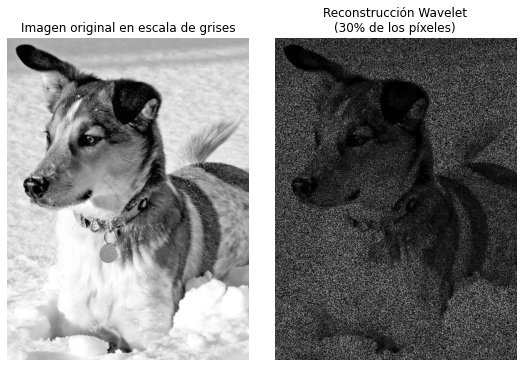

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
import pywt

# Carguemos la imagen y convirtámosla a escala de grises
A = imread('dog.jpeg')
B = rgb2gray(A)

# Creamos la máscara de muestreo midiendo el 30% de píxeles
np.random.seed(42)
porcentaje_muestreo = 0.3 # píxeles
mascara = np.random.random(B.shape) < porcentaje_muestreo
B_muestreada = B.copy()
B_muestreada[~mascara] = 0  # Cero en píxeles no muestreados

# Compresión con Wavelets
n = 4                # Niveles de descomposición wavelet
w = 'db1'            # Tipo de wavelet (Daubechies 1)
coeffs = pywt.wavedec2(B_muestreada, wavelet=w, level=n)  # Descomposición

# Conservemos solo los coeficientes más grandes
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
Csort = np.sort(np.abs(coeff_arr.reshape(-1))) # Ordenamos los coeficientes de menor a mayor
keep = 0.5 # Conservaremos el 50% de los coeficientes más grandes para ver mejor los detalles
thresh = Csort[int(np.floor((1-keep)*len(Csort)))]  # Umbral para los coeficientes
ind = np.abs(coeff_arr) > thresh
Cfilt = coeff_arr * ind  # Filtra coeficientes 

# Reconstrucción
coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')
B_reconstruida = pywt.waverec2(coeffs_filt, wavelet=w)

# Visualización
plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(B, cmap='gray')
plt.title('Imagen original en escala de grises')
plt.axis('off')

plt.subplot(142)
plt.imshow(B_reconstruida, cmap='gray', vmin=0, vmax=1)
plt.title(f'Reconstrucción Wavelet\n({porcentaje_muestreo*100:.0f}% de los píxeles)')
plt.axis('off')

plt.tight_layout()
plt.show()


2. Repetir la reconstrucción asumiendo que puedes medir el 45% de los píxeles.

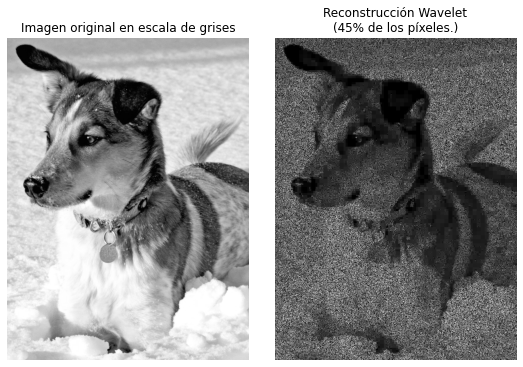

In [5]:
# Ahora, sólo se puede medir el 45% de píxeles
np.random.seed(42)
porcentaje_muestreo = 0.45 # píxeles
mascara = np.random.random(B.shape) < porcentaje_muestreo
B_muestreada = B.copy()
B_muestreada[~mascara] = 0  # Cero en píxeles no muestreados

# Compresión con Wavelets
n = 4                # Niveles de descomposición wavelet
w = 'db1'            # Tipo de wavelet (Daubechies 1)
coeffs = pywt.wavedec2(B_muestreada, wavelet=w, level=n)  # Descomposición

# Conservemos solo los coeficientes más grandes
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
Csort = np.sort(np.abs(coeff_arr.reshape(-1)))
keep = 0.3      # Como hay más información que antes, conservaremos menos coeficientes
thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
ind = np.abs(coeff_arr) > thresh
Cfilt = coeff_arr * ind

# Reconstrucción
coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')
B_reconstruida = pywt.waverec2(coeffs_filt, wavelet=w)

# Visualización
plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(B, cmap='gray')
plt.title('Imagen original en escala de grises')
plt.axis('off')

plt.subplot(142)
plt.imshow(B_reconstruida, cmap='gray', vmin=0, vmax=1)
plt.title(f'Reconstrucción Wavelet\n({porcentaje_muestreo*100:.0f}% de los píxeles.)')
plt.axis('off')

plt.tight_layout()
plt.show()

3. Finalmente, haz el algoritmo para que cuando se haya perdido la información de 20% de los píxeles y alguien te pregunte: ¿Puedes mejorar la imágen?, tu le digas : Claro, un segundo... Listo! (Nota: El ejercicio es realmente reconstruir al perro midiendo el 80% de los píxeles.)

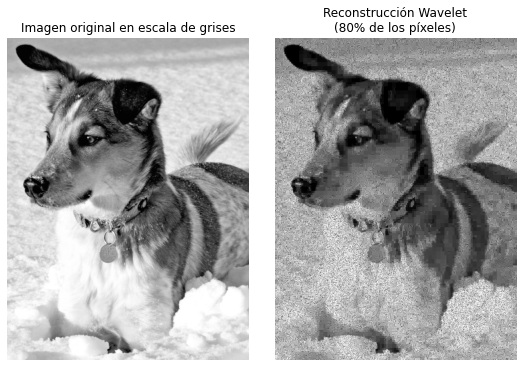

In [6]:
# En este apartado, se ha perdido el 20% de píxeles, es decir, se mide el 80% de ellos
np.random.seed(42)
porcentaje_muestreo = 0.8 # píxeles
mascara = np.random.random(B.shape) < porcentaje_muestreo
B_muestreada = B.copy()
B_muestreada[~mascara] = 0  # Cero en píxeles no muestreados

# Compresión con Wavelets
n = 4                # Niveles de descomposición wavelet
w = 'db1'            # Tipo de wavelet (Daubechies 1)
coeffs = pywt.wavedec2(B_muestreada, wavelet=w, level=n)  # Descomposición

# Conservemos solo los coeficientes más grandes
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
Csort = np.sort(np.abs(coeff_arr.reshape(-1)))
keep = 0.1      # Conservaremos muy pocos coeficientes
thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
ind = np.abs(coeff_arr) > thresh
Cfilt = coeff_arr * ind 

# Reconstrucción
coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')
B_reconstruida = pywt.waverec2(coeffs_filt, wavelet=w)

# Visualización
plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(B, cmap='gray')
plt.title('Imagen original en escala de grises')
plt.axis('off')

plt.subplot(142)
plt.imshow(B_reconstruida, cmap='gray', vmin=0, vmax=1)
plt.title(f'Reconstrucción Wavelet\n({porcentaje_muestreo*100:.0f}% de los píxeles)')
plt.axis('off')

plt.tight_layout()
plt.show()

## 3. Regresión y selección de modelo ##

Considere los siguientes datos de temperatura tomados a lo largo de un ciclo de 24 horas (tiempo militar):

| Temperatura | Hora |
| --- | --- |
| 75 | 01 |
| 57 | 09 |
| 49 | 17 |
| 77 | 02 |
| 55 | 10 |
| 50 | 18 |
| 76 | 03 |
| 53 | 11 |
| 54 | 19 |
| 73 | 04 |
| 52 | 12 |
| 56 | 20 |
| 69 | 05 |
| 50 | 13 |
| 59 | 21 |
| 68 | 06 |
| 50 | 14 |
| 63 | 22 |
| 63 | 07 |
| 49 | 15 |
| 67 | 23 |
| 59 | 08 |
| 49 | 16 |
| 72 | 24 |

Considere un ajuste polinomial de la forma:

\begin{equation*}
    f(x) = \sum_{k=0}^{10} a_k x^k
\end{equation*}

donde las cargas $a_k$ están determinadas por las cuatro técnicas de regresión:

(a) mínimos cuadrados

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Definamos los datos para la temperatura y el tiempo
temp = np.array([75, 57, 49, 77, 55, 50, 76, 53, 54, 73, 52, 56, 69, 50, 59, 68, 50, 63, 63, 49, 67, 59, 49, 72])
hora = np.array([1, 9, 17, 2, 10, 18, 3, 11, 19, 4, 12, 20, 5, 13, 21, 6, 14, 22, 7, 15, 23, 8, 16, 24])

# Grado del polinomio
grado = 10

modelo = make_pipeline(PolynomialFeatures(grado), LinearRegression(fit_intercept=False))
modelo.fit(hora.reshape(-1, 1), temp)

# Obtener los coeficientes
coef = modelo.named_steps['linearregression'].coef_

print("Coeficientes del polinomio:")
for k, ak in enumerate(coef):
    print(f"a_{k} = {ak:.2f}")

Coeficientes del polinomio:
a_0 = 58.01
a_1 = 31.40
a_2 = -19.91
a_3 = 6.59
a_4 = -1.34
a_5 = 0.17
a_6 = -0.01
a_7 = 0.00
a_8 = -0.00
a_9 = 0.00
a_10 = -0.00


(b) LASSO

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

# Creamos el modelo Lasso con un alpha pequeño para no sobre-regularizar
modelo_lasso = make_pipeline(PolynomialFeatures(10), Lasso(alpha=0.01, max_iter=100000, fit_intercept=False))
modelo_lasso.fit(hora.reshape(-1, 1), temp)

coef_lasso = modelo_lasso.named_steps['lasso'].coef_

print("Coeficientes (Lasso):")
for i, a in enumerate(coef_lasso):
    print(f"a_{i} = {a:.2f}")


Coeficientes (Lasso):
a_0 = 76.54
a_1 = 0.71
a_2 = -0.56
a_3 = 0.03
a_4 = 0.00
a_5 = -0.00
a_6 = -0.00
a_7 = 0.00
a_8 = 0.00
a_9 = 0.00
a_10 = -0.00


c:\Users\quech\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.794e+01, tolerance: 8.916e+00
  model = cd_fast.enet_coordinate_descent(


(c) Ridge

In [10]:
from sklearn.linear_model import Ridge

# Creamos el modelo Lasso con un alpha pequeño para no sobre-regularizar
modelo_ridge = make_pipeline(PolynomialFeatures(10), Ridge(alpha=1.0, max_iter=100000, fit_intercept=False))
modelo_ridge.fit(hora.reshape(-1, 1), temp)

coef_ridge = modelo_ridge.named_steps['ridge'].coef_

print("Coeficientes (Ridge):")
for i, a in enumerate(coef_ridge):
    print(f"a_{i} = {a:.2f}")

Coeficientes (Ridge):
a_0 = 25.53
a_1 = 21.45
a_2 = 9.27
a_3 = -7.05
a_4 = 1.70
a_5 = -0.22
a_6 = 0.02
a_7 = -0.00
a_8 = 0.00
a_9 = -0.00
a_10 = 0.00


c:\Users\quech\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.12142e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


(d) Elastic Net

In [11]:
from sklearn.linear_model import ElasticNet

# Creamos el modelo Lasso con un alpha pequeño para no sobre-regularizar
modelo_elastic = make_pipeline(PolynomialFeatures(10), ElasticNet(l1_ratio=0.5, max_iter=100000, fit_intercept=False))
modelo_elastic.fit(hora.reshape(-1, 1), temp)

coef_elastic = modelo_elastic.named_steps['elasticnet'].coef_

print("Coeficientes (Elastic Net):")
for i, a in enumerate(coef_elastic):
    print(f"a_{i} = {a:.2f}")

c:\Users\quech\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.773e+03, tolerance: 8.916e+00
  model = cd_fast.enet_coordinate_descent(


Coeficientes (Elastic Net):
a_0 = 9.29
a_1 = 13.52
a_2 = 0.34
a_3 = -0.23
a_4 = 0.01
a_5 = 0.00
a_6 = -0.00
a_7 = -0.00
a_8 = -0.00
a_9 = 0.00
a_10 = 0.00


*Finalmente, a manera de comprobación, incluyamos una gráfica para poder visualizar qué tan buenos son los coeficientes para los ajustes hechos anteriormente.*

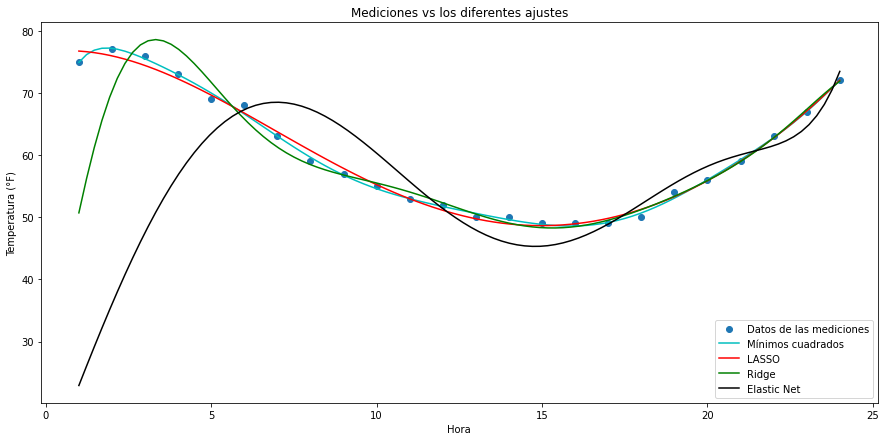

In [12]:
import matplotlib.pyplot as plt
horas = np.linspace(1, 24, 100)

plt.figure(figsize=(15,7))
plt.scatter(hora, temp, label='Datos de las mediciones')
plt.plot(horas, modelo.predict(horas.reshape(-1, 1)), 'c-', label='Mínimos cuadrados')
plt.plot(horas, modelo_lasso.predict(horas.reshape(-1, 1)), 'r-', label='LASSO')
plt.plot(horas, modelo_ridge.predict(horas.reshape(-1, 1)), 'g-', label='Ridge')
plt.plot(horas, modelo_elastic.predict(horas.reshape(-1, 1)), 'k-', label='Elastic Net')
plt.title('Mediciones vs los diferentes ajustes')
plt.xlabel('Hora')
plt.ylabel('Temperatura (°F)')
plt.legend()
plt.show()